In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.ticker import PercentFormatter

from functools import partial
from itertools import product
from contextlib import contextmanager

from xbbg import blp
from xbbg import __version__, const, pipeline
from xbbg.io import logs, files, storage
from xbbg.core import utils, conn, process
from xbbg.core.conn import connect

import datetime
from datetime import timedelta

sns.set(style = "white")

import scipy.stats as st


import warnings
warnings.filterwarnings("ignore")

In [2]:
def bdh_intra(tickers = None, start_date = datetime.datetime.now()-timedelta(days = 180), end_date = datetime.datetime.now(), 
              typ='TRADE', freq = 60, **kwargs):
    logger = logs.get_logger(bdh_intra, **kwargs)
    while conn.bbg_session(**kwargs).tryNextEvent(): pass
    request = process.create_request(
        service='//blp/refdata',
        request='IntradayBarRequest',
        settings = [
            ('security', tickers),
            ('eventType', typ),
            ('interval', freq),
            ('startDateTime', start_date),
            ('endDateTime', end_date)
        ],
        **kwargs,
    )
    logger.debug(f'Sending request to Bloomberg ...\n{request}')
    conn.send_request(request=request, **kwargs)

    res = pd.DataFrame(process.rec_events(process.process_bar, **kwargs))
    return res
    

In [3]:
def rr_signal(pair, lookback_days = 180, freq = 240, tenor = "3M", plot = False):
    vol_ticker = pair[0:6] + "V" + tenor + " CURNCY"
    rr_ticker = pair[0:6] + "25R" + tenor + " CURNCY"
    start_date = datetime.datetime.now()-timedelta(days = lookback_days)
    df_vol = bdh_intra(tickers = vol_ticker, freq = freq, start_date = start_date)
    df_vol = df_vol[["time", "close"]]
    df_rr = bdh_intra(tickers = rr_ticker, freq = freq, start_date = start_date)
    df_rr = df_rr[["time", "close"]]
    vol_series = df_vol["close"].values
    rr_series = df_rr["close"].values
    frame  = pd.DataFrame(index  = df_rr["time"].values)
    frame["vol"] = vol_series
    frame["rr"] = rr_series
    frame["ratio"] = frame["rr"] 
    mean_ratio = frame["ratio"].mean()
    stdev_ratio = frame["ratio"].std()
    frame["score"] = frame["ratio"].apply(lambda x: np.round(20*(st.norm.cdf((x-mean_ratio)/stdev_ratio)-0.5)))
    if plot == True:
        plt.figure(figsize = (7,7))
        plt.title("%s %s RR Score, %s - Day Lookback" % (pair, tenor, lookback_days))
        frame["score"].plot()
    if pair[0:3] == "USD":
        final = -1 * frame["score"].iloc[-1]
    else:
        final = frame["score"].iloc[-1]
    return final

In [4]:
rr_signal("GBPUSD CURNCY")

-4.0

In [5]:
rr_signal("AUDUSD CURNCY")

6.0

0.0

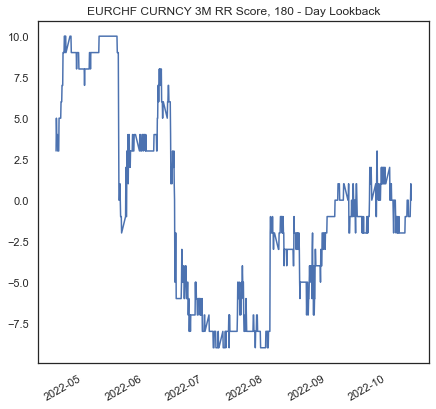

In [96]:
rr_signal("EURCHF CURNCY")

In [4]:
ccys = ["EURUSD", "GBPUSD", "USDCHF", "AUDUSD", "NZDUSD", "USDCAD", "USDNOK", "USDSEK", "USDJPY"]


In [5]:
print(datetime.datetime.now())
print("180-Day Lookback")
for ccy in ccys:
    if ccy[0:3] == "USD":
        currency = ccy[3:6]
    else:
        currency = ccy[0:3]
    print(currency,rr_signal(ccy + "CURNCY", plot = False))


2022-12-19 11:30:53.309608
180-Day Lookback
EUR 10.0
GBP 8.0
CHF 1.0
AUD 10.0
NZD 10.0
CAD 9.0
NOK 10.0
SEK 6.0
JPY 4.0


2022-12-19 11:31:28.891141
30-Day Lookback
EUR 6.0
GBP 7.0
CHF 8.0
AUD 9.0
NZD 7.0
CAD 8.0
NOK 7.0
SEK 8.0
JPY 1.0


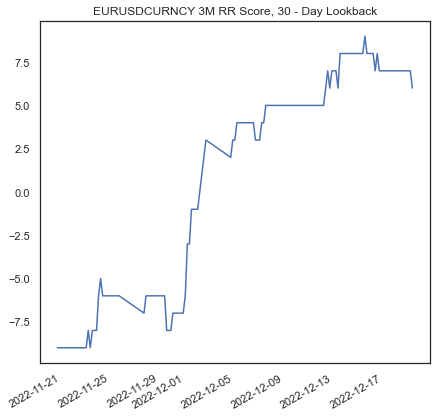

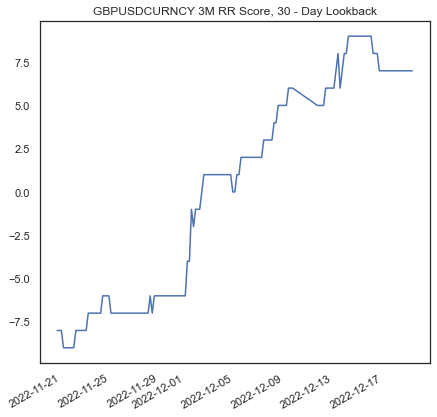

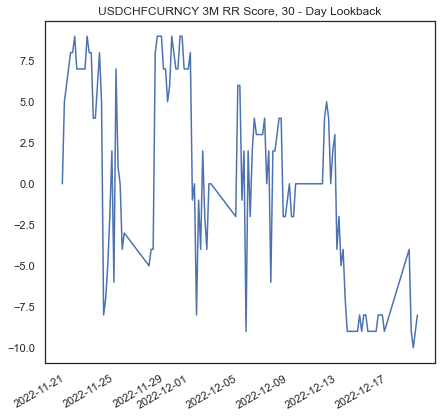

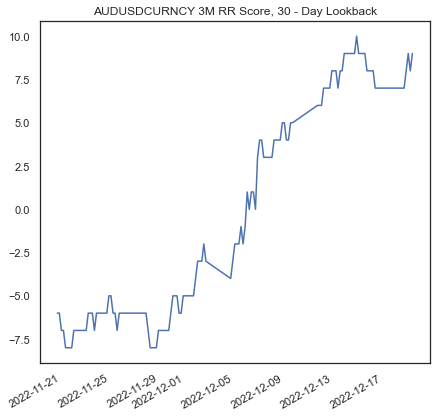

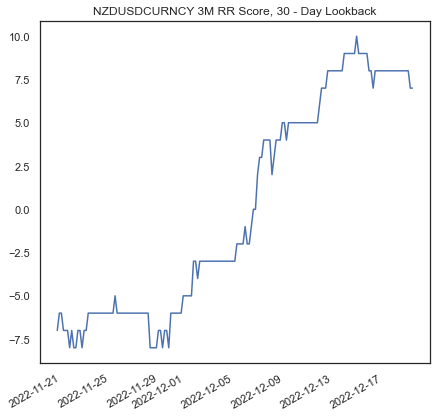

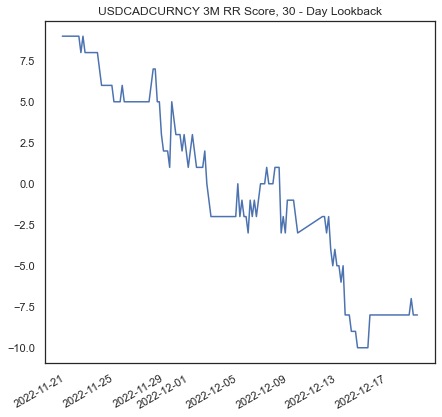

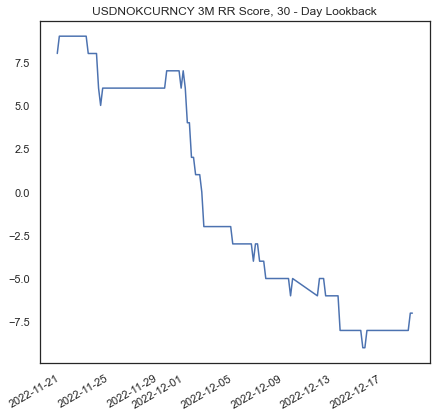

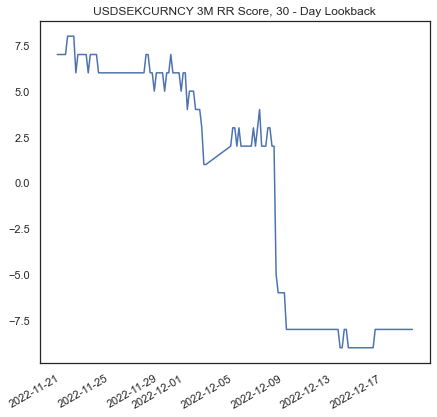

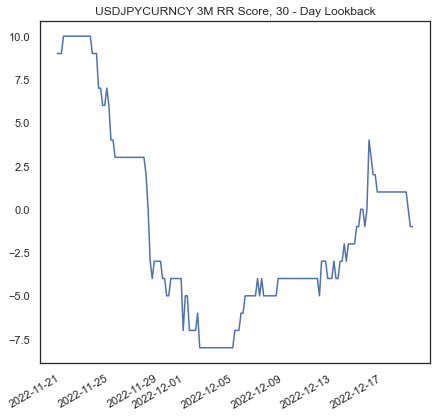

In [6]:
print(datetime.datetime.now())
print("30-Day Lookback")
for ccy in ccys:
    if ccy[0:3] == "USD":
        currency = ccy[3:6]
    else:
        currency = ccy[0:3]
    print(currency,rr_signal(ccy + "CURNCY", lookback_days = 30, plot = True))